## Training RGAN

In [1]:
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

# 1. RGAN model
from rgan import RecurrentGAN
# 2. Data loading
from data_loading import real_data_loading
# 3. Utils
from utils import Parameters
from shared.component_logger import component_logger as logger
import os

#Evaluating Synthetic Data
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

## Specify Hyperparameters

In [2]:
# Data loading
params = Parameters()
data_path = "data"
params.dataset = "stock"
params.data_path = os.path.join(data_path, "{}_data.csv".format(params.dataset))
params.model_save_path = os.path.join("checkpoints", params.dataset)

#Hyper-parameters
params.seq_len = 24
params.batch_size = 256
params.max_steps = 20000
params.save_model = True
params.print_every = 500

#set the device 
params.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocessing Data

In [3]:
#preprocessing the data.

"""
Method: real_data_loading()
---------------------------------------------------------------------------------------------------------------------
    - Loads the data from the path.
    - Scales the data using a min-max scaler.
    - Slices the data into windows of size seq_len.
    - Shuffles the data randomly, and returns it.
"""
ori_data, (minimum, maximum) = real_data_loading(params.data_path, params.seq_len)

params.input_size = ori_data[0].shape[1]
params.latent_dim = params.input_size # For the sake of simplicity, we assume the latent dimension is the same as the input dimension.
params.hidden_size = 24
params.num_layers = 3
params.disc_extra_steps = 1 # The number of times the discriminator is trained more than the generator.

logger.log("Preprocessing Complete!")
   

with open(os.path.join(data_path, "{}_real_data.npy".format(params.dataset)), 'wb') as f:
    np.save(f, np.array(ori_data))

logger.log("Saved real data!")

2022-07-28 09:15:25.961041: INFO: recurrent_gan: <cell line: 19>: Preprocessing Complete!
2022-07-28 09:15:25.981949: INFO: recurrent_gan: <cell line: 25>: Saved real data!


## Running RGAN

In [4]:
"""
Method: train()
---------------------------------------------------------------------------------------------------------------------
    - Trains the RGAN model, and saves model weights.
"""

rgan = RecurrentGAN(params)
rgan.train(ori_data)  

2022-07-28 09:15:27.783244: INFO: recurrent_gan: __init__: Traininable Parameters in Generator: 9,696
2022-07-28 09:15:27.798952: INFO: recurrent_gan: __init__: Traininable Parameters in Discriminator: 25,969
2022-07-28 09:15:28.087220: INFO: recurrent_gan: train: [Step 0; L(D): 1.3804; L(G): 0.6675]
2022-07-28 09:15:34.645640: INFO: recurrent_gan: train: [Step 500; L(D): 0.5017; L(G): 1.9509]
2022-07-28 09:15:41.251951: INFO: recurrent_gan: train: [Step 1000; L(D): 1.3784; L(G): 0.4986]
2022-07-28 09:15:47.623053: INFO: recurrent_gan: train: [Step 1500; L(D): 1.0342; L(G): 0.9613]
2022-07-28 09:15:53.836450: INFO: recurrent_gan: train: [Step 2000; L(D): 1.2294; L(G): 0.7942]
2022-07-28 09:16:00.956421: INFO: recurrent_gan: train: [Step 2500; L(D): 1.2369; L(G): 0.8727]
2022-07-28 09:16:08.220009: INFO: recurrent_gan: train: [Step 3000; L(D): 1.3536; L(G): 0.9141]
2022-07-28 09:16:15.492577: INFO: recurrent_gan: train: [Step 3500; L(D): 1.3083; L(G): 0.7784]
2022-07-28 09:16:22.646519:

## Loading pretrained models from checkpoint paths

In [5]:
generator_path = "./checkpoints/stock_generator.pth"
rgan.load_model("generator", generator_path)

## Generate Synthetic Data

In [6]:
sample_size = 3661
generated_data = rgan.generate_synthetic_data(sample_size)

## Evaluating Synthetic Data

In [7]:
# Loading the real data, and synthetic data.

with open(os.path.join(data_path, "{}_real_data.npy".format(params.dataset)), 'rb') as f:
    ori_data = np.load(f)

logger.log(ori_data.shape)
logger.log(generated_data.shape)

2022-07-28 09:20:12.675861: INFO: recurrent_gan: <cell line: 6>: (3661, 24, 6)
2022-07-28 09:20:12.693803: INFO: recurrent_gan: <cell line: 7>: (3661, 24, 6)


### 1. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis for **Diversity**.

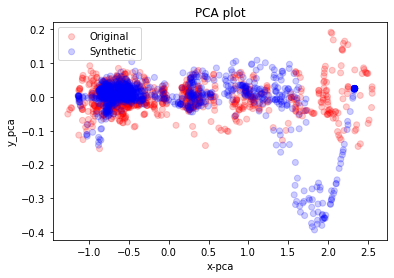

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.033199
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.000546
[t-SNE] KL divergence after 300 iterations: 0.771804


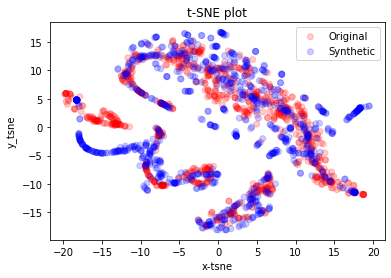

In [8]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')


### 2. Discriminative score
To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.



*   metric_iteration: the number of iterations for metric computation.




In [9]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
    temp_disc = discriminative_score_metrics(ori_data, generated_data)
    discriminative_score.append(temp_disc)

logger.log('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use tf.global_variables instead.
2022-07-28 09:32:59.295515: INFO: recurrent_gan: <cell line: 8>: Discriminative score: 0.1783


### 3. Predictive score
To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [10]:
predictive_score = list()
for tt in range(metric_iteration):
    temp_pred = predictive_score_metrics(ori_data, generated_data)
    predictive_score.append(temp_pred)   

logger.log('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

2022-07-28 09:49:05.807654: INFO: recurrent_gan: <cell line: 6>: Predictive score: 0.0383
